In [ ]:
# packages

import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from PIL import Image
import re
from tqdm import tqdm

from functions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(int(time.time()))


In [58]:
# load each image into a vector

def load_data():
    images = os.listdir('images/')
    classes = []
    classcounts = {}
    for image in images:
        c = re.findall("[a-zA-Z_]+", image)[0]
        if c not in classes:
            classes.append(c)
            classcounts[c] = 1
        else:
            classcounts[c] += 1
            
    print("{} classes: {}".format(len(classes), classes))
    print("class counts: {}".format(classcounts))
    
    x = []
    y = []
    

    for image in tqdm(images):
        img = Image.open('images/'+image)
        pix = img.load()
        w,h = img.size
        
        matrix_in = np.empty([w,h,3])

        
        try:
            for color in range(3):
                for x_coord in range(w):
                    for y_coord in range(h):
                        matrix_in[x_coord,y_coord,color] = int(pix[x_coord,y_coord][color])
            
            x.append(matrix_in)
            
            
            matrix_out = np.zeros([len(classes)])
            c = re.findall("[a-zA-Z_]+", image)[0] # c is the class
            pos = classes.index(c)
            matrix_out[pos] = 1            
            
            y.append(matrix_out)

        except:
            print('bad image')
        
    test_x_orig = []
    test_y = []
    
    test_num = 250
    for i in range(test_num):
        random_num = np.random.randint(0,len(x))
        test_x_orig.append(x.pop(random_num))
        test_y.append(y.pop(random_num))
        
    train_x_orig = np.asarray(np.stack(x))
    train_y = np.asarray(np.transpose(np.stack(y)))
    
    test_x_orig = np.asarray(np.stack(test_x_orig))
    test_y = np.asarray(np.transpose(np.stack(test_y)))
    
    return train_x_orig, train_y, test_x_orig, test_y, classes
    
        
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()


  0%|▍                                                                                                                                          | 8/2496 [00:00<00:32, 76.94it/s]

6 classes: ['car', 'city_bus', 'fire_hydrant', 'motorcycle', 'stop_sign', 'traffic_light']
class counts: {'car': 650, 'city_bus': 330, 'fire_hydrant': 285, 'motorcycle': 252, 'stop_sign': 523, 'traffic_light': 456}


 13%|█████████████████▎                                                                                                                       | 315/2496 [00:03<00:25, 84.37it/s]

bad image


 15%|█████████████████████                                                                                                                    | 384/2496 [00:04<00:28, 75.09it/s]

bad image


 45%|█████████████████████████████████████████████████████████████▋                                                                          | 1131/2496 [00:13<00:15, 87.13it/s]

bad image


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2496/2496 [00:29<00:00, 83.65it/s]


In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 2243
Number of testing examples: 250
Each image is of size: (64, 64, 3)
train_x_orig shape: (2243, 64, 64, 3)
train_y shape: (6, 2243)
test_x_orig shape: (250, 64, 64, 3)
test_y shape: (6, 250)


In [9]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 2243)
test_x's shape: (12288, 250)


In [10]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 6
layers_dims = (n_x, n_h, n_y)

In [11]:
# implements 2 layer network

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" matrix of shape (5, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}, {}".format(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 4.169487675107868, 4.169487675107868
Cost after iteration 100: 2.713308094481775, 2.713308094481775
Cost after iteration 200: 2.609495121096611, 2.609495121096611
Cost after iteration 300: 2.2854360303126318, 2.2854360303126318
Cost after iteration 400: 2.105322035342081, 2.105322035342081
Cost after iteration 500: 1.9069337238011181, 1.9069337238011181
Cost after iteration 600: 1.7515918680451317, 1.7515918680451317
Cost after iteration 700: 1.6345028254689569, 1.6345028254689569
Cost after iteration 800: 1.5479412644133148, 1.5479412644133148
Cost after iteration 900: 1.479646091071319, 1.479646091071319
Cost after iteration 1000: 1.420820136787438, 1.420820136787438
Cost after iteration 1100: 1.3694698537804733, 1.3694698537804733
Cost after iteration 1200: 1.3253336942206881, 1.3253336942206881
Cost after iteration 1300: 1.2868216437676514, 1.2868216437676514
Cost after iteration 1400: 1.2523563357995853, 1.2523563357995853
Cost after iteration 1500: 1.22086

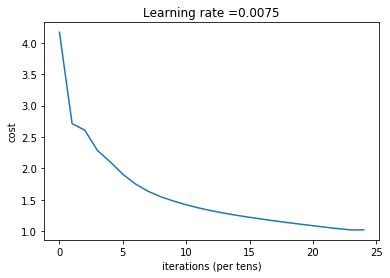

In [16]:
# compute network parameteres, outputting cost along the way

parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets, run the cell below.

In [17]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.936914846188141


In [18]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.908666666666667


In [53]:
### CONSTANTS ###
layers_dims = [12288, 7, 7, 7, 6] #  4-layer model

In [54]:
# implements the l layer network

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" matrix of shape (5, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 4.158883724557591
Cost after iteration 100: 3.7297996451115827
Cost after iteration 200: 3.433301088273151
Cost after iteration 300: 3.225950099653514
Cost after iteration 400: 3.078746828500081
Cost after iteration 500: 2.9725961371415144
Cost after iteration 600: 2.8948885249363974
Cost after iteration 700: 2.83720438113394
Cost after iteration 800: 2.7938384559999068
Cost after iteration 900: 2.7608629022193334
Cost after iteration 1000: 2.7355304253798507
Cost after iteration 1100: 2.7158904077932737
Cost after iteration 1200: 2.7005379489358816
Cost after iteration 1300: 2.6884479983232055
Cost after iteration 1400: 2.6788635984768865
Cost after iteration 1500: 2.6712195853401908
Cost after iteration 1600: 2.665089727862221
Cost after iteration 1700: 2.660149607902234
Cost after iteration 1800: 2.656150215714988
Cost after iteration 1900: 2.6528989460242984
Cost after iteration 2000: 2.650245767168715
Cost after iteration 2100: 2.6480730518463376
Cost after

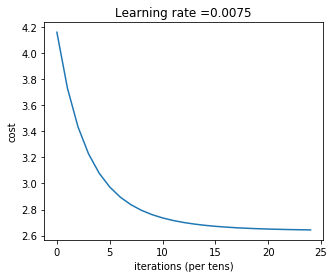

In [55]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [61]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.8333333333333336


In [62]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8333333333333335
